# A4MD: Validation of conformational space - Early termination of trajectories


---

## Overview

Through this notebook we are able to validate that the early termination of our framework A4MD covers the conformational space as the full simulation.
This notebook also provides visual representatations that helps to analyze the trimmed trajectories in comparison with the full simulation.

We are using the FS peptide system  (Ace-A 5(AAARA) 3A-NME) and its trajectories collected using Summit supercomputer. We use the trajectories of the full simulation and also trajectories with early termination usgin collective variables (CVs) such as Largest Eigen Value (LEV) and Effective Sample Size (ESS)

---

The following two cells prepares the environment for processing and visualizing the trajectories by importing various crucial libraries for the execution.

In [1]:
# This code allows to reload the code in the notebook without restarting the kernel. Since we are using an external file with functions,
# this automatically loads the new modifications of that file into the notebook.
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries needed for the execution of the notebook
import pyemma.coordinates as coor
import mdtraj as md
from pyemma.util.contexts import settings
import numpy as np
import matplotlib as mpl
import pyemma
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
import A4MD_utils as a4md_utils
from IPython.display import display


import pkg_resources
print("PyEmma version: ", pkg_resources.get_distribution("pyemma").version)

# You have have successfully prepared your environment.
print("You have successfully prepared your environment.")

PyEmma version:  2.5.12
You have successfully prepared your environment.


## Define parameters
This cell defines some variables we need to load the trajectories, analize them and also, save frames on disk.


In [3]:
stride = 10  # Stride for loading trajectory
selection= "protein" # Used for the RMSD comparison. This option can be "protein" or "all"
input_dirs = [
    "/make_sure_you_set_the_path_to_the_data/trajectories/output.checkpoint",
    "/make_sure_you_set_the_path_to_the_data/trajectories/output",
] # Path fot the full trajectories of the simulation. Each folder containes 20 trajectories
trimmed_trajectories_lev = (
    "/make_sure_you_set_the_path_to_the_data/trimmed_trajectories_lev_chk_rest.xtc"
) # Path for the trimmed trajectories of the simulation using LEV
trimmed_trajectories_ess = (
    "/make_sure_you_set_the_path_to_the_data/trimmed_trajectories_ess_chk_rest.xtc"
) # Path for the trimmed trajectories of the simulation using ESS

top_file = "/make_sure_you_set_the_path_to_the_data/trajectories/output.checkpoint/fs_1_traj_1/setup/boxed.pdb" # Topology file for the trajectories
nstates = 6 # Number of states for the MSM model and the PCCA+
anotations = [
    "/home/exouser/trajectories/output.checkpoint/analysis/ann.trajs20.stride10.window_lev200.window_ess500.rangeth5.stableth80.varth10",
    "/home/exouser/trajectories/output/analysis/ann.trajs20.stride10.window_lev200.window_ess500.rangeth5.stableth80.varth10",
] # Path for the annotations files. The annotations files contains the information of the LEV and ESS termination
SAVE_FRAMES = True # If True, the frames will be saved in the folder frames_closest
frames_closest_folder = "/make_sure_you_set_the_path_to_the_folder/" # Folder where the frames will be saved
dist_cmap = 'nipy_spectral' # Color map for the energy plots
size=20 # Size of the point in the plots


## Loading Full trajectory

We start by creating a variable that contains every path of the full (40) trajectories

In [4]:
trajs = []
for i in range(1, 21):
    if i % 10 == 0:
        conformation = 10
    else:
        conformation = i % 10

    traj_path = (
        "/home/exouser/trajectories/output.checkpoint/fs_"
        + str(conformation)
        + "_traj_"
        + str(i)
        + "/out_md/traj_comp_whole.xtc"
    )
    trajs.append(traj_path)
    # print(traj_path)

    traj_path = (
        "/home/exouser/trajectories/output/fs_"
        + str(conformation)
        + "_traj_"
        + str(i)
        + "/out_md/traj_comp_whole.xtc"
    )
    trajs.append(traj_path)
    # print(traj_path)

We load the trajectories as an MDtraj object. For this we use the previous variable that contains every path of the trajectories and the topological file.

In [5]:
mdtrajectories = md.load(trajs, top=top_file)

We finally load the backbone torsions of the topological file and add them into memory so we have all the trajectories with their correspondent features

In [6]:
feat = coor.featurizer(top_file) 
feat.add_backbone_torsions()
# features_ref = coor.load(trajs, feat)
features_ref = feat.transform(mdtrajectories)

## Calculating Tica

To analyze the conformational space, we first create its 2D representation by applying a time-lagged Independent
Component Analysis (tICA) decomposition method to the full trajectories. We choose a time lag of 5000.

To do this task we use Pyemma's libraries. 



In [7]:
with settings(show_progress_bars=True):
    tica_obj = coor.tica(features_ref, lag=5000, stride=stride)

/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


We load the data from our tICA object using the get_output() function, which maps all input data and returns it as an array or list of arrays

In [8]:
tica_outpu = tica_obj.get_output()

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

Finally we concatenate the all the values of the tICA space in a single variable.

In [9]:
tica_concatenated_full = np.concatenate(tica_outpu)

## Clustering
To discretize the full space of the tICA space we use k-means clustering.

From now, we use only the first two tICA components which reflect the two slowest degrees of freedom.

In [10]:
clust = coor.cluster_kmeans(
    tica_concatenated_full[:,:2], k=200, stride=stride, fixed_seed=True #, metric="minRMSD"
)
dtrajs = clust.dtrajs # Discretized trajectories
cc_x = clust.clustercenters[:, 0] # Cluster centers of the first tICA component
cc_y = clust.clustercenters[:, 1] # Cluster centers of the second tICA component
dtrajs_concatenated = np.concatenate(dtrajs) # Concatenated discretized trajectories

/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/10 [00:00<?, ?it/s]

26-07-24 22:08:13 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


## Loading Trimmed trajectories (LEV and ESS)

To do the comparison we need to load the trajectories that have been early terminated with the use of our A4MD framework. 

To cut the trajectories, we leverage two essential quantities that we compute in situ as an MD simulation evolves: the largest eigenvalue of alpha-Carbon (C𝛼) distance matrices (LEV) capturing molecular states and the effective sample size (ESS) identifying fast transitions of molecular states. 

To start the loading process we set the source of these trajectures by using the source() function of Pyemma's library and use the same features as for the full trajectories

In [11]:
mdtraj_trimmed_trajectories_lev = coor.source([trimmed_trajectories_lev], features=feat)
mdtraj_trimmed_trajectories_ess = coor.source([trimmed_trajectories_ess], features=feat)

We load the trajectories as MDtraj objects

In [12]:
mdtrajectories_trimmed_lev = md.load(trimmed_trajectories_lev, top=top_file)
mdtrajectories_trimmed_ess = md.load(trimmed_trajectories_ess, top=top_file)

Finally we map all input data as a list of arrays

In [13]:
loaded_trajs_lev= mdtraj_trimmed_trajectories_lev.get_output()
loaded_trajs_ess = mdtraj_trimmed_trajectories_ess.get_output()

## Calculating tICA for trimmed trajectories using the full tICA object

Since we have the tICA object of the full trajectories, we map the trimmed trajectories into the same space, to that end we use the transform() function of Pyemma

In [14]:
tica_transformed_trim_lev = tica_obj.transform(loaded_trajs_lev)
tica_transformed_trim_ess = tica_obj.transform(loaded_trajs_ess)

As we did with the full trajectories, we concatenate the trimmed trajectories in a single variable.

In [15]:
tica_concatenated_trim_lev = np.concatenate(tica_transformed_trim_lev)
tica_concatenated_trim_ess = np.concatenate(tica_transformed_trim_ess)

## Clustering
Assigning trimmed data to the cluster centers of the full trajectory suing the euclidean distance

In [16]:
dtrajs_trimmed_lev = coor.assign_to_centers(tica_concatenated_trim_lev[:,:2], clust.clustercenters, metric='euclidean',return_dtrajs=True)
dtrajs_trimmed_ess = coor.assign_to_centers(tica_concatenated_trim_ess[:,:2], clust.clustercenters, metric='euclidean',return_dtrajs=True)

/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "assign_to_centers". Called from /home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.ClusterModel instead.
  return caller(func, *(extras + args), **kw)
/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "assign_to_centers". Called from /home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.ClusterModel instead.
  return caller(func, *(extras + args), **kw)


## Estimating Markov Model

We build a Markov State Model (MSM) to describe the dynamics and kinetics of the Fs peptide folding. 

We create three MSM, one for the full trajectories, one for the trajectories trimmed using LEV and one for the trajectories trimmed using ESS.

We select a time lag of 100 and use the VAMP method

In [17]:
M = pyemma.msm.estimate_markov_model(dtrajs, lag=100, score_method="VAMP1")
MT_lev = pyemma.msm.estimate_markov_model(dtrajs_trimmed_lev, lag=100, score_method="VAMP1")
MT_ess = pyemma.msm.estimate_markov_model(dtrajs_trimmed_ess, lag=100, score_method="VAMP1")

## Doing PCCA+

We perform another clustering method. Now we use the Perron-Cluster Clustering Analysis (PCCA) to do a fuzzy clustering.

Here we use the number of states defined at the beggining. The number of states were defined in our previous work.

In [18]:

M.pcca(nstates)
MT_lev.pcca(nstates)
MT_ess.pcca(nstates)

PCCA-139686030721088:[{'P': array([[0.08548387, 0.        , 0.00201602, ..., 0.0302452 , 0.02016137,
                             0.        ],
                            [0.        , 0.06253521, 0.00056309, ..., 0.        , 0.        ,
                             0.00056259],
                            [0.00105048, 0.00042038, 0.11344538, ..., 0.00042024, 0.00042019,
                             0.02308852],
                            ...,
                            [0.06636452, 0.        , 0.00176962, ..., 0.0619469 , 0.01238809,
                             0.00176804],
                            [0.0254841 , 0.        , 0.00101931, ..., 0.00713632, 0.07441386,
                             0.00152759],
                            [0.        , 0.00052761, 0.02900385, ..., 0.00052743, 0.00079106,
                             0.08377239]]),
                      'm': None}]

We map the cluster assignments of the trimmed data to the metastable states and then get the metastable states.

During this task we use the same assignments of the full model because we want to map the trimmed points in the same clusters identified by the PCCA.

In [19]:
metastable_traj = M.metastable_assignments[dtrajs_concatenated]
metastable_assignments_trimmed_lev = M.metastable_assignments[dtrajs_trimmed_lev]
metastable_assignments_trimmed_ess = M.metastable_assignments[dtrajs_trimmed_ess]

pcca_sets = M.metastable_sets
pcca_setsT = MT_lev.metastable_sets
pcca_setsT_ess = MT_ess.metastable_sets

## Plotting state maps
We use one of the functions from Pyemma to visualize the state maps that we got from doing the PCCA.

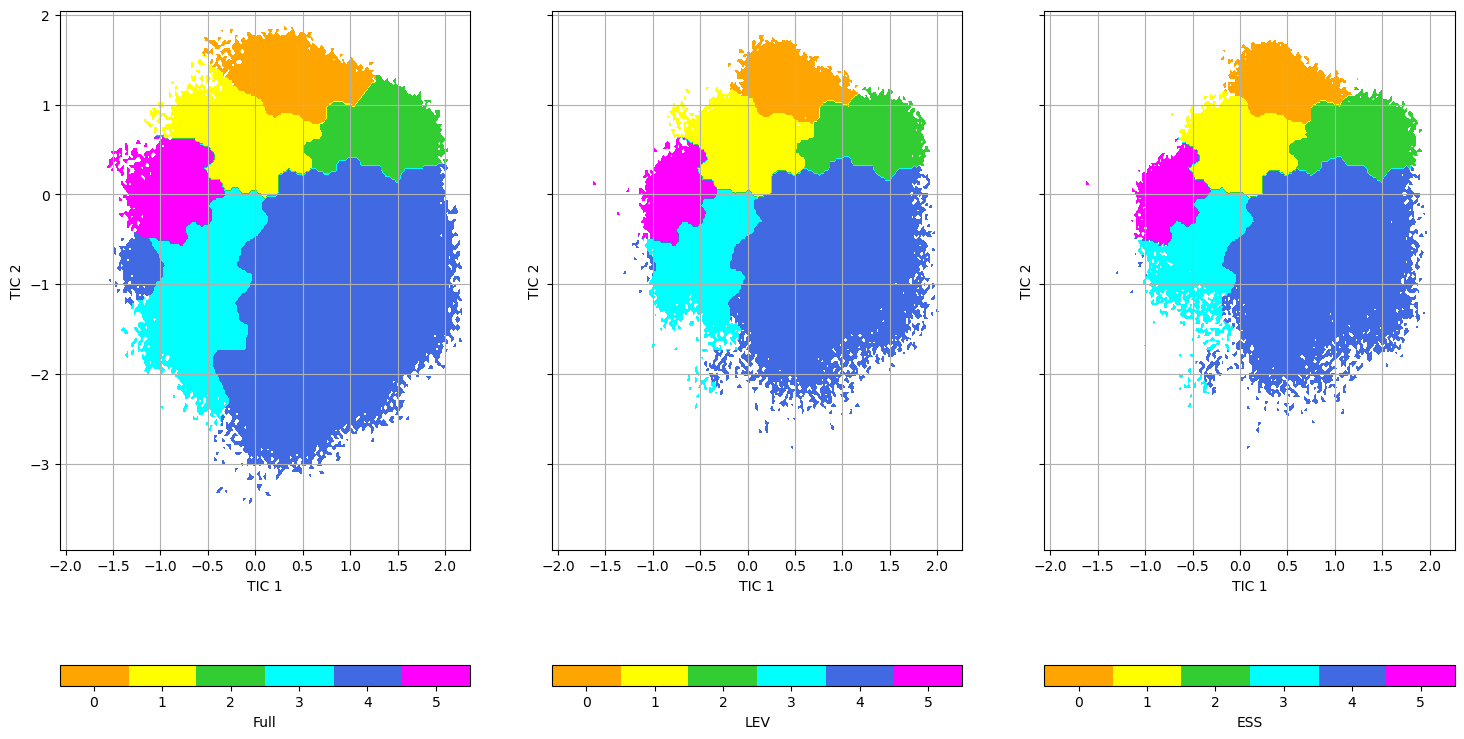

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 10))
cols = ["orange", "yellow", "limegreen", "cyan", "royalblue", "magenta"]
cmap = mpl.colors.ListedColormap(cols)
pyemma.plots.plot_state_map(
    tica_concatenated_full[:, 0],
    tica_concatenated_full[:, 1],
    metastable_traj,
    cbar_label="Full",
    cbar=True,
    cbar_orientation="horizontal",
    cmap=cmap,
    ncontours=300,
    nbins=200,
    ax=ax1,
)
ax1.set_xlabel("TIC 1")
ax1.set_ylabel("TIC 2")
pyemma.plots.plot_state_map(
    tica_concatenated_trim_lev[:, 0],
    tica_concatenated_trim_lev[:, 1],
    np.asarray(metastable_assignments_trimmed_lev).reshape(-1),
    cbar_label="LEV",
    cbar=True,
    cbar_orientation="horizontal",
    cmap=cmap,
    ncontours=300,
    nbins=200,
    ax=ax2,
)
ax2.set_xlabel("TIC 1")
ax2.set_ylabel("TIC 2")
pyemma.plots.plot_state_map(
    tica_concatenated_trim_ess[:, 0],
    tica_concatenated_trim_ess[:, 1],
    np.asarray(metastable_assignments_trimmed_ess).reshape(-1),
    cbar_label="ESS",
    cbar=True,
    cbar_orientation="horizontal",
    cmap=cmap,
    ncontours=300,
    nbins=200,
    ax=ax3,
)
ax3.set_xlabel("TIC 1")
ax3.set_ylabel("TIC 2")
ax1.grid()
ax2.grid()
ax3.grid()

# Calculating Energy

Now we calculate the Free Energy landscape for the three models we have (Full, LEV and ESS). We do this calculation using three different methods: umbrella sampling, Boltzmann equation and the method provided by Pyemma to do this calculation.

## Umbrella Sampling


We use the transition counts to calculate the transition matrix, which represents the probabilities of transitioning from one state to another. The dwell times are calculated as the inverse of the sum of transition probabilities for each state. The transition rates are then obtained by dividing the transition matrix by the dwell times.

The equilibrium probabilities are calculated using the eigenvectors of the transpose of the transition rates matrix. These probabilities represent the long-term distribution of states in the system.

Finally, the free energy differences between each pair of states are calculated using the equilibrium probabilities and the gas constant and temperature values. The free energy values are then converted from joules to kcal/mol.



In [21]:
# Get the transition counts
counts = M.count_matrix_full
countsT_lev = MT_lev.count_matrix_full
countsT_ess = MT_ess.count_matrix_full

# Calculate the transition matrix
transition_matrix = counts / counts.sum(axis=1)[:, np.newaxis]
transition_matrixT_lev = countsT_lev / countsT_lev.sum(axis=1)[:, np.newaxis]
transition_matrixT_ess = countsT_ess / countsT_ess.sum(axis=1)[:, np.newaxis]

# Calculate the dwell times
dwell_times = 1 / transition_matrix.sum(axis=1)
dwell_timesT_lev = 1 / transition_matrixT_lev.sum(axis=1)
dwell_timesT_ess = 1 / transition_matrixT_ess.sum(axis=1)

# Calculate the transition rates
transition_rates = transition_matrix / dwell_times[:, np.newaxis]
transition_ratesT_lev = transition_matrixT_lev / dwell_timesT_lev[:, np.newaxis]
transition_ratesT_ess = transition_matrixT_ess / dwell_timesT_ess[:, np.newaxis]

# Constants
R = 8.314462618  # Gas constant in J/(mol*K)
T = 298.15  # Temperature in K

# Calculate the equilibrium probabilities
equilibrium_probabilities = np.linalg.eig(transition_rates.T)[1][:, 0]
equilibrium_probabilitiesT_lev = np.linalg.eig(transition_ratesT_lev.T)[1][:, 0]
equilibrium_probabilitiesT_ess = np.linalg.eig(transition_ratesT_ess.T)[1][:, 0]
equilibrium_probabilities /= equilibrium_probabilities.sum()
equilibrium_probabilitiesT_lev /= equilibrium_probabilitiesT_lev.sum()
equilibrium_probabilitiesT_ess /= equilibrium_probabilitiesT_ess.sum()

# Calculate the free energy difference between each pair of states
u_free_energy = -R * T * np.log(equilibrium_probabilities)
u_free_energyT_lev = -R * T * np.log(equilibrium_probabilitiesT_lev)
u_free_energyT_ess = -R * T * np.log(equilibrium_probabilitiesT_ess)
# Convert from joules to kcal/mol
u_free_energy /= 4184
u_free_energyT_lev /= 4184
u_free_energyT_ess /= 4184
# Cut the free energy to the minimum value
min_full = np.min(u_free_energy)
u_free_energy -= np.min(u_free_energy)
u_free_energyT_lev -= min_full
u_free_energyT_lev -= np.min(u_free_energyT_lev)
u_free_energyT_ess -= min_full
u_free_energyT_ess -= np.min(u_free_energyT_ess)




## Stationary Distribution - Energy


This cell calculates the free energies for three different distributions: full, trimmed, and trimmed ess.
It uses the Boltzmann equation based on stationary distributions and total distributions of each distribution to calculate the probabilities (pi).
The free energies are then calculated as the negative logarithm of the probabilities.
The minimum value of the free energies for the full distribution is subtracted from all the free energies.


In [22]:

# Full
stationary_distribution = M.stationary_distribution
total_distribution = float(stationary_distribution.sum())
pi = stationary_distribution / total_distribution
free_energies = -np.log(pi)
min_full = np.min(free_energies)
free_energies -= np.min(free_energies)

# LEV
stationary_distributionT_lev = MT_lev.stationary_distribution
total_distributionT_lev = float(stationary_distributionT_lev.sum())
piT = stationary_distributionT_lev / total_distributionT_lev
free_energiesT_lev = -np.log(piT)
free_energiesT_lev -= min_full
free_energiesT_lev -= np.min(free_energiesT_lev)

# ESS
stationary_distributionT_ess = MT_ess.stationary_distribution
total_distributionT_ess = float(stationary_distributionT_ess.sum())
piT_ess = stationary_distributionT_ess / total_distributionT_ess
free_energiesT_ess = -np.log(piT_ess)
free_energiesT_ess -= min_full
free_energiesT_ess -= np.min(free_energiesT_ess)



## PyEmma's Method

Here we follow the code that Pyemma includes to do the Free Energy calculation.

This code calculates the 2D histogram and free energy for the three models we have.
It performs the following steps:

1. Define the edges for the x and y axes based on the minimum and maximum values of the data points.
2. Calculate the 2D histogram using the `np.histogram2d` function.
3. Calculate the probability distribution and free energy for each bin.
4. Adjust the free energy values by subtracting the minimum free energy.
5. Digitize the cluster center coordinates to determine the corresponding bin indices.
6. Set the infinite free energy values to a large negative value.
7. Calculate the maximum free energy value.
8. Adjust the free energy values by subtracting the minimum free energy again.
9. Get the free energy values for each cluster center by indexing the free energy array with the cluster bin indices.
10. Adjust the free energy values for each cluster center by subtracting the minimum free energy again.


In [23]:
x_edges = np.linspace(np.min(tica_concatenated_full[:, 0]), np.max(tica_concatenated_full[:, 0]), 200)
y_edges = np.linspace(np.min(tica_concatenated_full[:, 1]), np.max(tica_concatenated_full[:, 1]), 200)

# Calculate the 2D histogram
hist, x_edges, y_edges = np.histogram2d(tica_concatenated_full[:, 0], tica_concatenated_full[:, 1], bins=[x_edges, y_edges])
# Calculate the free energy for each bin
total_distribution =  float(hist.sum())
pi = hist / float(hist.sum())
free_energy = np.inf * np.ones(shape=hist.shape)
nonzero = pi.nonzero()
free_energy[nonzero] = -np.log(pi[nonzero])
min_full = np.min(free_energy[nonzero])
free_energy[nonzero] -= np.min(free_energy[nonzero])

cluster_bins_x = np.digitize(cc_x, x_edges) - 1
cluster_bins_y = np.digitize(cc_y, y_edges) - 1
free_energy[free_energy == np.inf] = -1000
maxval = np.amax(free_energy)
free_energy[free_energy == -1000] = maxval

##------------------------------------------------------------------------------
x_edges = np.linspace(np.min(tica_concatenated_trim_lev[:, 0]), np.max(tica_concatenated_trim_lev[:, 0]), 200)
y_edges = np.linspace(np.min(tica_concatenated_trim_lev[:, 1]), np.max(tica_concatenated_trim_lev[:, 1]), 200)

# Calculate the 2D histogram
histT, x_edgest, y_edgest = np.histogram2d(tica_concatenated_trim_lev[:, 0], tica_concatenated_trim_lev[:, 1], bins=[x_edges, y_edges])

pi = histT / float(histT.sum())
free_energyT_lev = np.inf * np.ones(shape=histT.shape)
nonzero = pi.nonzero()
free_energyT_lev[nonzero] = -np.log(pi[nonzero])
free_energyT_lev[nonzero] -= min_full
free_energyT_lev[nonzero] -= np.min(free_energyT_lev[nonzero])

cluster_bins_xT = np.digitize(cc_x, x_edgest) - 1
cluster_bins_yT = np.digitize(cc_y, y_edgest) - 1
free_energyT_lev[free_energyT_lev == np.inf] = -1000
maxval = np.amax(free_energyT_lev)
free_energyT_lev[free_energyT_lev == -1000] = maxval

##------------------------------------------------------------------------------
x_edges = np.linspace(np.min(tica_concatenated_trim_ess[:, 0]), np.max(tica_concatenated_trim_ess[:, 0]), 200)
y_edges = np.linspace(np.min(tica_concatenated_trim_ess[:, 1]), np.max(tica_concatenated_trim_ess[:, 1]), 200)

# Calculate the 2D histogram
histT_ess, x_edgest_ess, y_edgest_ess = np.histogram2d(tica_concatenated_trim_ess[:, 0], tica_concatenated_trim_ess[:, 1], bins=[x_edges, y_edges])
pi = histT_ess / float(histT_ess.sum())
free_energyT_ess = np.inf * np.ones(shape=histT_ess.shape)
nonzero = pi.nonzero()
free_energyT_ess[nonzero] = -np.log(pi[nonzero])
free_energyT_ess[nonzero] -= min_full
free_energyT_ess[nonzero] -= np.min(free_energyT_ess[nonzero])

cluster_bins_xT_ess = np.digitize(cc_x, x_edgest_ess) - 1
cluster_bins_yT_ess = np.digitize(cc_y, y_edgest_ess) - 1
free_energyT_ess[free_energyT_ess == np.inf] = -1000
maxval = np.amax(free_energyT_ess)
free_energyT_ess[free_energyT_ess == -1000] = maxval

# Get the free energy for each cluster center
free_energy_per_cluster = free_energy[cluster_bins_x, cluster_bins_y]
free_energy_per_cluster -= np.min(free_energy_per_cluster)
free_energy_per_clusterT_lev = free_energyT_lev[cluster_bins_xT, cluster_bins_yT]
free_energy_per_clusterT_lev -= np.min(free_energy_per_clusterT_lev)
free_energy_per_clusterT_ess = free_energyT_ess[cluster_bins_xT_ess, cluster_bins_yT_ess]
free_energy_per_clusterT_ess -= np.min(free_energy_per_clusterT_ess)
    


## Finding Frames closest to minimum free energy
To find the most representatives structures per state, we find the closest frames to the minimum values per state.

We find the 10 closest frames, so we can compare them to verify whether their structure is similar or not.

We do this for every model (Full, LEV and ESS) and Free Energy calculation method (umbrella sampling, Boltzmann equation and Pyemma's)



In [52]:
## TODO: change to dataframe structure or create a class with these attributes so we only pass the object
print("Umbrella")
(
    frames_closest_to_minimum_energy_coor_umbrella,
    frames_closest_to_minimum_energy_coor_T_lev_umbrella,
    frames_closest_to_minimum_energy_coor_T_ess_umbrella,
    frames_closest_to_minimum_energy_umbrella,
    frames_closest_to_minimum_energyT_lev_umbrella,
    frames_closest_to_minimum_energyT_ess_umbrella,
    frames_10_closest_to_minimum_energy_umbrella,
    frames_10_closest_to_minimum_energyT_lev_umbrella,
    frames_10_closest_to_minimum_energyT_ess_umbrella,
    minimum_energy_umbrella,
    minimum_energyT_lev_umbrella,
    minimum_energyT_ess_umbrella,
) = a4md_utils.find_frames_closest_to_minimum_energy(
    u_free_energy,
    u_free_energyT_lev,
    u_free_energyT_ess,
    M,
    MT_lev,
    MT_ess,
    clust,
    tica_concatenated_full,
    tica_concatenated_trim_lev,
    tica_concatenated_trim_ess,
    nstates,
)
print("Pyemma")
(
    frames_closest_to_minimum_energy_coor_pyemma,
    frames_closest_to_minimum_energy_coor_T_lev_pyemma,
    frames_closest_to_minimum_energy_coor_T_ess_pyemma,
    frames_closest_to_minimum_energy_pyemma,
    frames_closest_to_minimum_energyT_lev_pyemma,
    frames_closest_to_minimum_energyT_ess_pyemma,
    frames_10_closest_to_minimum_energy_pyemma,
    frames_10_closest_to_minimum_energyT_lev_pyemma,
    frames_10_closest_to_minimum_energyT_ess_pyemma,
    minimum_energy_pyemma,
    minimum_energyT_lev_pyemma,
    minimum_energyT_ess_pyemma,
) = a4md_utils.find_frames_closest_to_minimum_energy(
    free_energy_per_cluster,
    free_energy_per_clusterT_lev,
    free_energy_per_clusterT_ess,
    M,
    MT_lev,
    MT_ess,
    clust,
    tica_concatenated_full,
    tica_concatenated_trim_lev,
    tica_concatenated_trim_ess,
    nstates,
)

print("Stationary")
(
    frames_closest_to_minimum_energy_coor_stationary,
    frames_closest_to_minimum_energy_coor_T_lev_stationary,
    frames_closest_to_minimum_energy_coor_T_ess_stationary,
    frames_closest_to_minimum_energy_stationary,
    frames_closest_to_minimum_energyT_lev_stationary,
    frames_closest_to_minimum_energyT_ess_stationary,
    frames_10_closest_to_minimum_energy_stationary,
    frames_10_closest_to_minimum_energyT_lev_stationary,
    frames_10_closest_to_minimum_energyT_ess_stationary,
    minimum_energy_stationary,
    minimum_energyT_stationary,
    minimum_energyT_ess_stationary,
) = a4md_utils.find_frames_closest_to_minimum_energy(
    free_energies,
    free_energiesT_lev,
    free_energiesT_ess,
    M,
    MT_lev,
    MT_ess,
    clust,
    tica_concatenated_full,
    tica_concatenated_trim_lev,
    tica_concatenated_trim_ess,
    nstates,
)

Umbrella
Pyemma
Stationary


## Energy Ranking - PyEmma

In [53]:

data = {
    'State': range(0, len(minimum_energy_pyemma)),
    'Minimum Energy (PyEmma)': minimum_energy_pyemma,
    'Minimum Energy (PyEmmaT)': minimum_energyT_lev_pyemma,
    'Minimum Energy (PyEmmaT_ess)': minimum_energyT_ess_pyemma,
}

df = pd.DataFrame(data)
df_sorted = df.sort_values(by='Minimum Energy (PyEmma)')
display(df_sorted)



,State,Minimum Energy (PyEmma),Minimum Energy (PyEmmaT),Minimum Energy (PyEmmaT_ess)
5,5,0.000000,0.000000,0.000000
0,0,2.200579,1.262412,0.063312
1,1,2.310509,1.840294,0.845255
2,2,2.717905,1.222496,0.468777
3,3,2.947409,1.785378,1.068399
4,4,3.552482,2.383909,0.904095


## Saving closest frames to disk as pdb files

We save the closest frames to disk to visualize them using VMD and to do the RMSD calculation later.

The folder that contains the frames will have the 10 closest frames but also the closest one. We name this folder with the datetime.

In [54]:
## TODO: change to dataframe structure or create a class with these attributes so we only pass the object
if SAVE_FRAMES:
    folder = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    folder_path = f"{frames_closest_folder}{folder}"
    os.mkdir(folder_path)
    folder_path_10 = f"{folder_path}/frames_10"
    os.mkdir(folder_path_10)

    frames_10_total_umbrella, frames_10_files_umbrella = a4md_utils.save_10_frames(
        folder_path_10,
        "umbrella",
        frames_10_closest_to_minimum_energy_umbrella,
        mdtrajectories,
        "full",
    )

    frames_10_total_pyemma, frames_10_files_pyemma = a4md_utils.save_10_frames(
        folder_path_10,
        "pyemma",
        frames_10_closest_to_minimum_energy_pyemma,
        mdtrajectories,
        "full",
    )

    frames_10_total_stationary, frames_10_files_stationary = a4md_utils.save_10_frames(
        folder_path_10,
        "stationary",
        frames_10_closest_to_minimum_energy_stationary,
        mdtrajectories,
        "full",
    )

    frames_10T_lev_total_umbrella, frames_10_filesT_lev_umbrella = a4md_utils.save_10_frames(
        folder_path_10,
        "umbrella",
        frames_10_closest_to_minimum_energyT_lev_umbrella,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )

    frames_10T_lev_total_pyemma, frames_10_filesT_lev_pyemma = a4md_utils.save_10_frames(
        folder_path_10,
        "pyemma",
        frames_10_closest_to_minimum_energyT_lev_pyemma,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )

    frames_10T_lev_total_stationary, frames_10_filesT_lev_stationary = a4md_utils.save_10_frames(
        folder_path_10,
        "stationary",
        frames_10_closest_to_minimum_energyT_lev_stationary,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )

    frames_10T_ess_total_umbrella, frames_10_filesT_ess_umbrella = a4md_utils.save_10_frames(
        folder_path_10,
        "umbrella",
        frames_10_closest_to_minimum_energyT_ess_umbrella,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )

    frames_10T_ess_total_pyemma, frames_10_filesT_ess_pyemma = a4md_utils.save_10_frames(
        folder_path_10,
        "pyemma",
        frames_10_closest_to_minimum_energyT_ess_pyemma,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )

    frames_10T_ess_total_stationary, frames_10_filesT_ess_stationary = a4md_utils.save_10_frames(
        folder_path_10,
        "stationary",
        frames_10_closest_to_minimum_energyT_ess_stationary,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )

    frames_minimum_umbrella, frames_minimum_files_umbrella = a4md_utils.save_frames(
        folder_path,
        "umbrella",
        frames_closest_to_minimum_energy_umbrella,
        mdtrajectories,
        "full",
    )
    frames_minimum_pyemma, frames_minimum_files_pyemma = a4md_utils.save_frames(
        folder_path,
        "pyemma",
        frames_closest_to_minimum_energy_pyemma,
        mdtrajectories,
        "full",
    )
    frames_minimum_stationary, frames_minimum_files_stationary = a4md_utils.save_frames(
        folder_path,
        "stationary",
        frames_closest_to_minimum_energy_stationary,
        mdtrajectories,
        "full",
    )

    frames_minimumT_lev_umbrella, frames_minimum_filesT_lev_umbrella = a4md_utils.save_frames(
        folder_path,
        "umbrella",
        frames_closest_to_minimum_energyT_lev_umbrella,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )
    frames_minimumT_lev_pyemma, frames_minimum_filesT_lev_pyemma = a4md_utils.save_frames(
        folder_path,
        "pyemma",
        frames_closest_to_minimum_energyT_lev_pyemma,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )
    frames_minimumT_lev_stationary, frames_minimum_filesT_lev_stationary = a4md_utils.save_frames(
        folder_path,
        "stationary",
        frames_closest_to_minimum_energyT_lev_stationary,
        mdtrajectories_trimmed_lev,
        "trim_lev",
    )

    frames_minimumT_ess_umbrella, frames_minimum_filesT_ess_umbrella = a4md_utils.save_frames(
        folder_path,
        "umbrella",
        frames_closest_to_minimum_energyT_ess_umbrella,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )
    frames_minimumT_ess_pyemma, frames_minimum_filesT_ess_pyemma = a4md_utils.save_frames(
        folder_path,
        "pyemma",
        frames_closest_to_minimum_energyT_ess_pyemma,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )
    frames_minimumT_ess_stationary, frames_minimum_filesT_ess_stationary = a4md_utils.save_frames(
        folder_path,
        "stationary",
        frames_closest_to_minimum_energyT_ess_stationary,
        mdtrajectories_trimmed_ess,
        "trim_ess",
    )

## Visualizing Free energy landscapes and minimum per state
We use the tricontour plot to visualize the Free Energy landscape for all the three methods we used. In this plot we also present the cluster centers that we got from the kmeans clustering, in every color we also see the different states and as a white star we see the minimum Free Energy points

/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/matplotlib/tri/_triangulation.py:181: ComplexWarning: Casting complex values to real discards the imaginary part
  triangles = np.asarray(triangles, dtype=np.int32)
/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/matplotlib/tri/_tricontour.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z_check.max())
/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/matplotlib/tri/_tricontour.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z_check.min())
/home/exouser/anaconda3/envs/testMolpx/lib/python3.8/site-packages/matplotlib/tri/_tricontour.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  C = _tri.TriContourGenerator(tri.get_cpp_triangulation(), z)


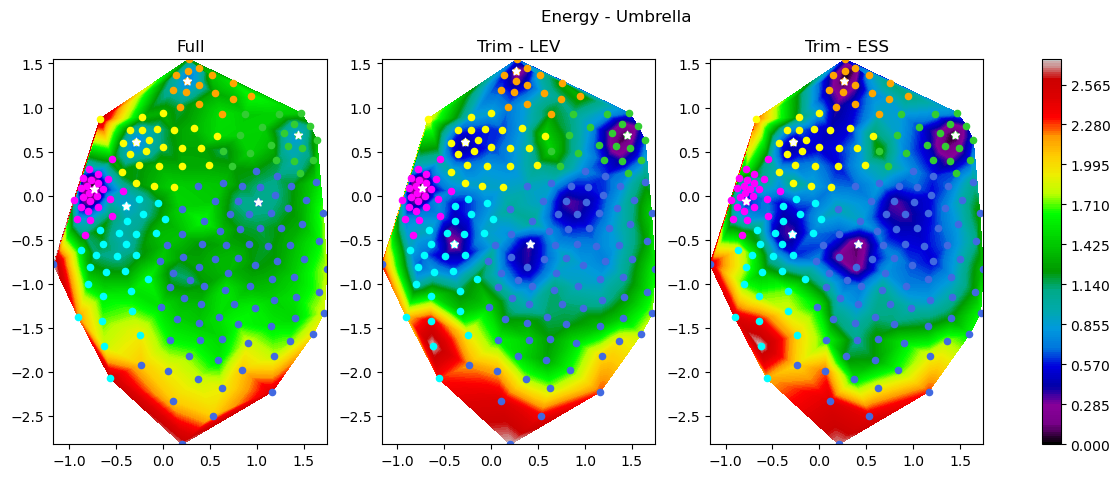

In [56]:
a4md_utils.plot_free_energy(
    cc_x,
    cc_y,
    u_free_energy,
    u_free_energyT_lev,
    u_free_energyT_ess,
    dist_cmap,
    "Energy - Umbrella",
    nstates,
    pcca_sets,
    cols,
    size,
    frames_closest_to_minimum_energy_coor_umbrella,
    frames_closest_to_minimum_energy_coor_T_lev_umbrella,
    frames_closest_to_minimum_energy_coor_T_ess_umbrella,
)

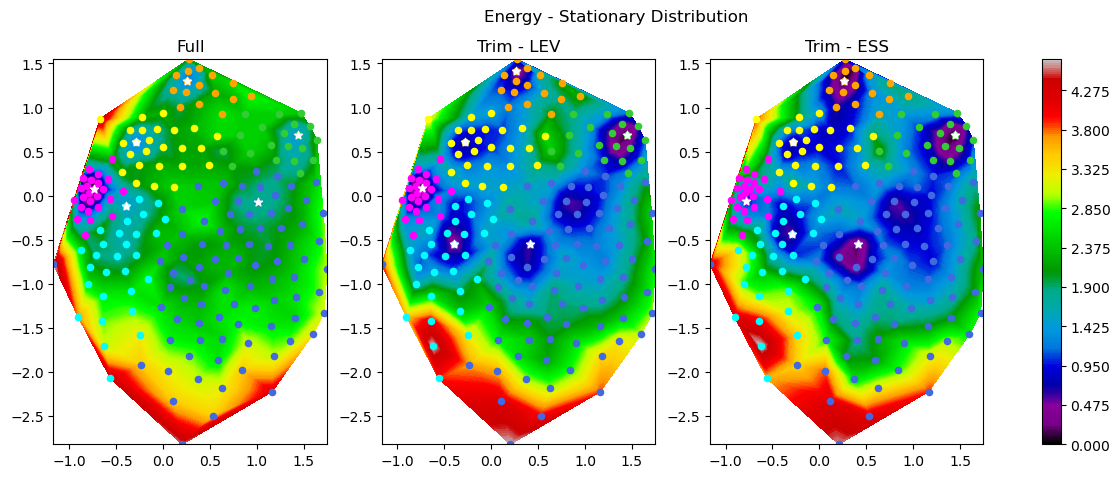

In [57]:
a4md_utils.plot_free_energy(
    cc_x,
    cc_y,
    free_energies,
    free_energiesT_lev,
    free_energiesT_ess,
    dist_cmap,
    "Energy - Stationary Distribution",
    nstates,
    pcca_sets,
    cols,
    size,
    frames_closest_to_minimum_energy_coor_stationary,
    frames_closest_to_minimum_energy_coor_T_lev_stationary,
    frames_closest_to_minimum_energy_coor_T_ess_stationary,
)

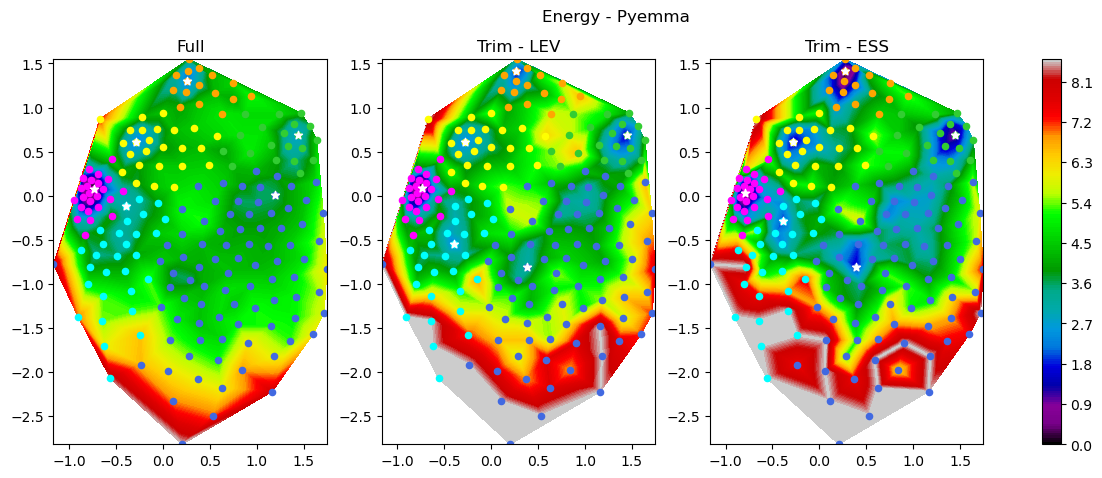

In [58]:
a4md_utils.plot_free_energy(
    cc_x,
    cc_y,
    free_energy_per_cluster,
    free_energy_per_clusterT_lev,
    free_energy_per_clusterT_ess,
    dist_cmap,
    "Energy - Pyemma",
    nstates,
    pcca_sets,
    cols,
    size,
    frames_closest_to_minimum_energy_coor_pyemma,
    frames_closest_to_minimum_energy_coor_T_lev_pyemma,
    frames_closest_to_minimum_energy_coor_T_ess_pyemma,
)

# Calculating RMSD average within same states (10 Closest Frames)
We take the 10 closest frames and calculate the RMSD average among them. We are using two methods to do this. The mdtraj method aligns all the frames and then does the comparison. The Compute method does the comparison without aligning the frames. For both methods we use the closest frame to the minium Free Energy point as reference. We do this only for Pyemma's Free Energy due to this one represented better the landscape comparing it to the full simulation

In [59]:
data_average_rmsd = {'State': range(0, len(minimum_energy_pyemma))}
data_average_rmsd["full_mdtraj"] = a4md_utils.calculate_average_rmsd(frames_10_total_pyemma, frames_10_files_pyemma, 'mdtraj', nstates, selection)
data_average_rmsd["full_compute"] = a4md_utils.calculate_average_rmsd(frames_10_total_pyemma, frames_10_files_pyemma, 'compute', nstates, selection)

data_average_rmsd["lev_mdtraj"] = a4md_utils.calculate_average_rmsd(frames_10T_lev_total_pyemma, frames_10_filesT_lev_pyemma, 'mdtraj', nstates, selection)
data_average_rmsd["lev_compute"] = a4md_utils.calculate_average_rmsd(frames_10T_lev_total_pyemma, frames_10_filesT_lev_pyemma, 'compute', nstates, selection)

data_average_rmsd["ess_mdtraj"] = a4md_utils.calculate_average_rmsd(frames_10T_ess_total_pyemma, frames_10_filesT_ess_pyemma, 'mdtraj', nstates, selection)
data_average_rmsd["ess_compute"] = a4md_utils.calculate_average_rmsd(frames_10T_ess_total_pyemma, frames_10_filesT_ess_pyemma, 'compute', nstates, selection)
df_average_rmsd = pd.DataFrame(data_average_rmsd)
display(df_average_rmsd)



,State,full_mdtraj,full_compute,lev_mdtraj,lev_compute,ess_mdtraj,ess_compute
0,0,0.323081,50.089713,0.290587,46.260651,0.288862,47.778279
1,1,0.520770,44.952083,0.552644,49.780792,0.467274,49.997989
2,2,0.464271,37.269174,0.488787,45.885438,0.494390,46.659244
3,3,0.569863,45.577728,0.713142,43.441287,0.549316,48.687972
4,4,0.794743,51.708508,0.573028,63.393096,0.535335,65.164458
5,5,0.285227,57.684933,0.426819,60.843829,0.367746,35.779341


## Calculating RMSD Values and comparing them (Closest frame)
Now, we do the calculation of the RMSD comparison among all the closest frames to the minimum point. We do this for every energy method, and every model.

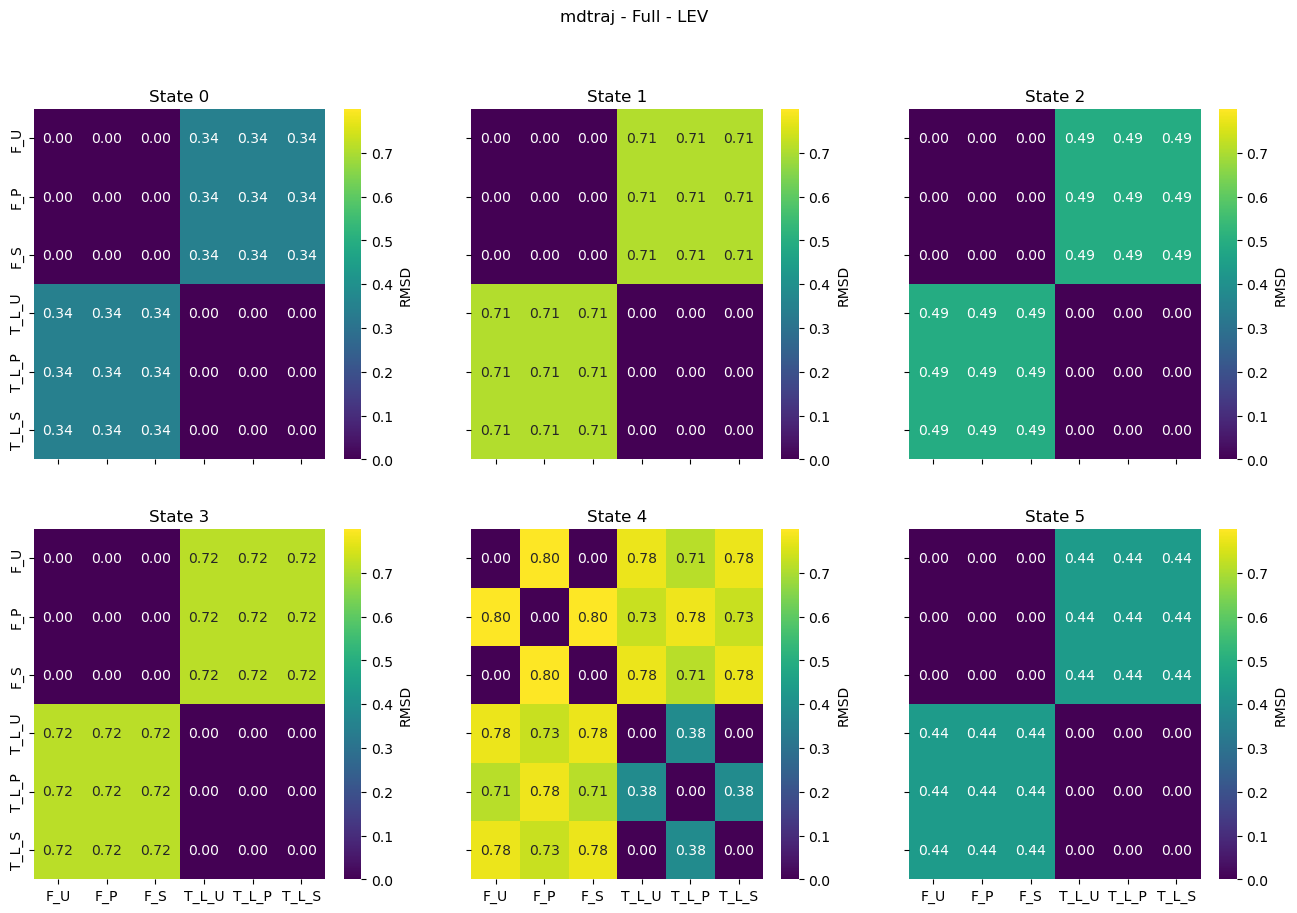

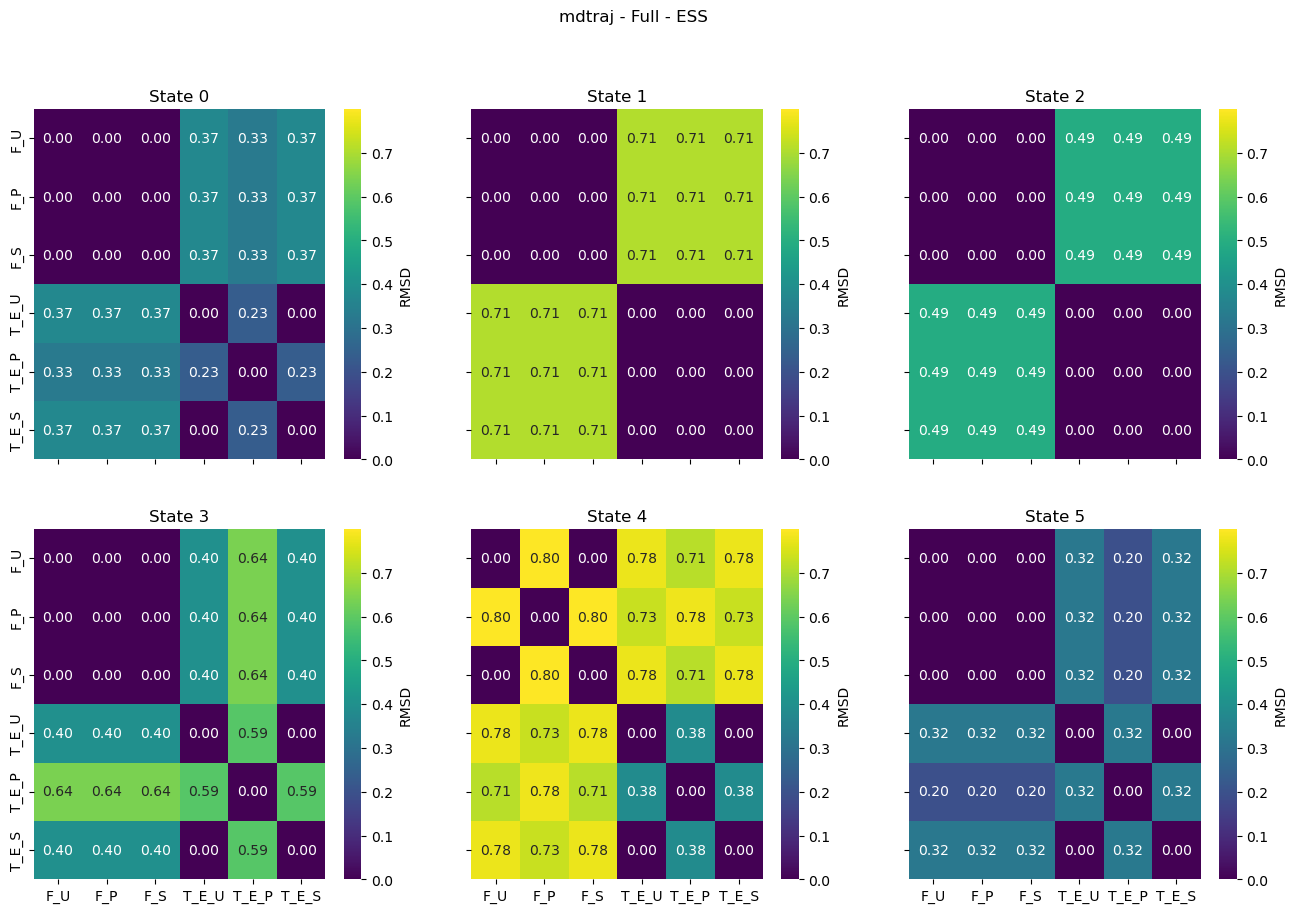

In [60]:
a4md_utils.calculate_rmsd_values_s(
    frames_minimum_umbrella,
    frames_minimum_pyemma,
    frames_minimum_stationary,
    frames_minimumT_lev_umbrella,
    frames_minimumT_lev_pyemma,
    frames_minimumT_lev_stationary,
    frames_minimum_files_umbrella,
    frames_minimum_files_pyemma,
    frames_minimum_files_stationary,
    frames_minimum_filesT_lev_umbrella,
    frames_minimum_filesT_lev_pyemma,
    frames_minimum_filesT_lev_stationary,
    ["F_U", "F_P", "F_S", "T_L_U", "T_L_P", "T_L_S"],
    "mdtraj",
    nstates,
    selection,
    "mdtraj - Full - LEV",
    [0,1,2,3,4,5]
)
a4md_utils.calculate_rmsd_values_s(
    frames_minimum_umbrella,
    frames_minimum_pyemma,
    frames_minimum_stationary,
    frames_minimumT_ess_umbrella,
    frames_minimumT_ess_pyemma,
    frames_minimumT_ess_stationary,
    frames_minimum_files_umbrella,
    frames_minimum_files_pyemma,
    frames_minimum_files_stationary,
    frames_minimum_filesT_ess_umbrella,
    frames_minimum_filesT_ess_pyemma,
    frames_minimum_filesT_ess_stationary,
    ["F_U", "F_P", "F_S", "T_E_U", "T_E_P", "T_E_S"],
    "mdtraj",
    nstates,
    selection,
    "mdtraj - Full - ESS",
    [0,1,2,3,4,5]
)

## Notations used in the plots:
# F_U: Full - Umbrella
# F_P: Full - Pyemma
# F_S: Full - Stationary
# T_L_U: Trimmed LEV - Umbrella
# T_L_P: Trimmed LEV - Pyemma
# T_L_S: Trimmed LEV - Stationary
# T_E_U: Trimmed ESS - Umbrella
# T_E_P: Trimmed ESS - Pyemma
# T_E_S: Trimmed ESS - Stationary


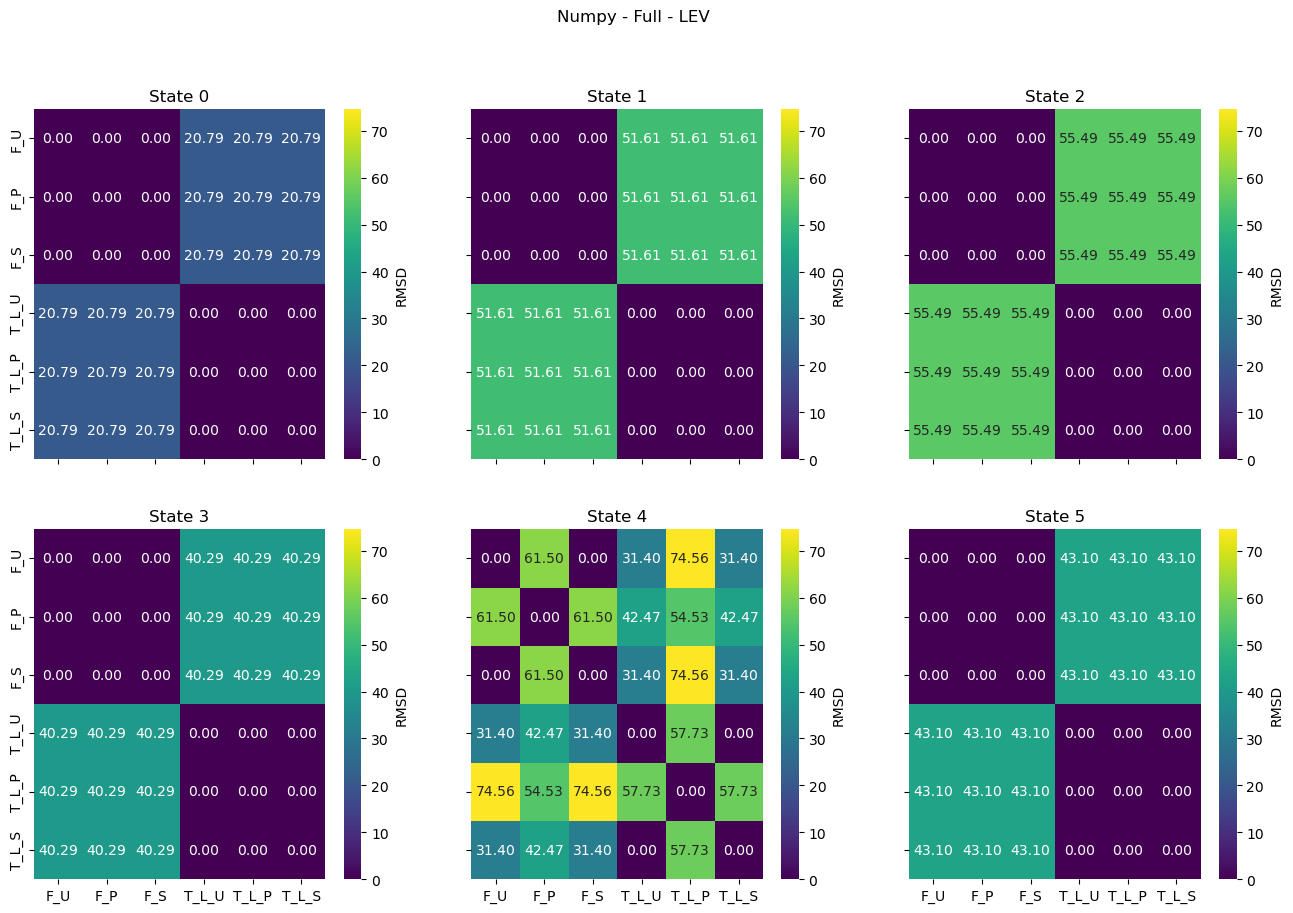

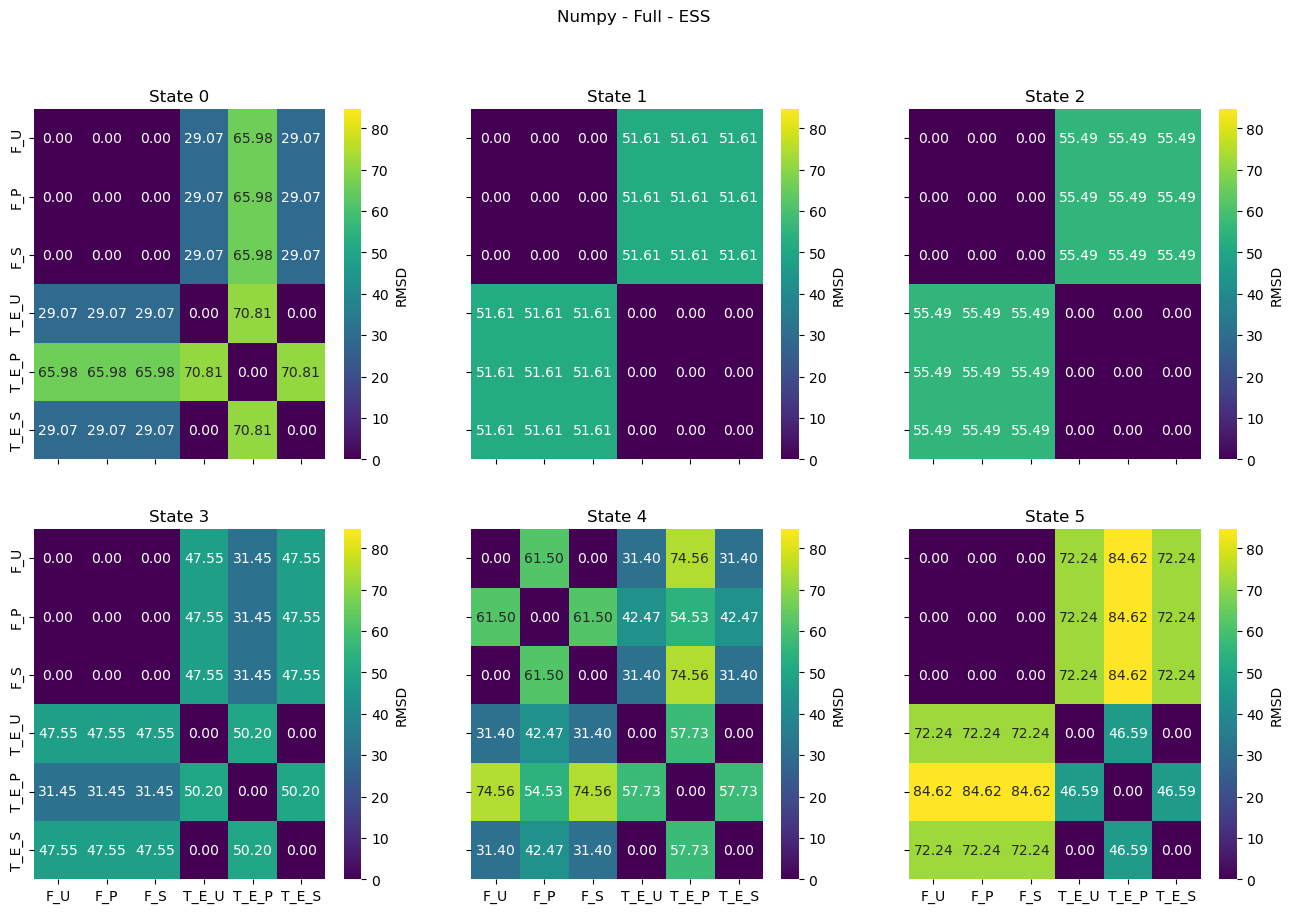

In [61]:
a4md_utils.calculate_rmsd_values_s(
    frames_minimum_umbrella,
    frames_minimum_pyemma,
    frames_minimum_stationary,
    frames_minimumT_lev_umbrella,
    frames_minimumT_lev_pyemma,
    frames_minimumT_lev_stationary,
    frames_minimum_files_umbrella,
    frames_minimum_files_pyemma,
    frames_minimum_files_stationary,
    frames_minimum_filesT_lev_umbrella,
    frames_minimum_filesT_lev_pyemma,
    frames_minimum_filesT_lev_stationary,
    ["F_U", "F_P", "F_S", "T_L_U", "T_L_P", "T_L_S"],
    "compute",
    nstates,
    selection,
    "Numpy - Full - LEV",
    [0,1,2,3,4,5]
)
a4md_utils.calculate_rmsd_values_s(
    frames_minimum_umbrella,
    frames_minimum_pyemma,
    frames_minimum_stationary,
    frames_minimumT_ess_umbrella,
    frames_minimumT_ess_pyemma,
    frames_minimumT_ess_stationary,
    frames_minimum_files_umbrella,
    frames_minimum_files_pyemma,
    frames_minimum_files_stationary,
    frames_minimum_filesT_ess_umbrella,
    frames_minimum_filesT_ess_pyemma,
    frames_minimum_filesT_ess_stationary,
    ["F_U", "F_P", "F_S", "T_E_U", "T_E_P", "T_E_S"],
    "compute",
    nstates,
    selection,
    "Numpy - Full - ESS",
    [0,1,2,3,4,5]
)

## HMM
We do the estimation of the Hidden Markov Model that can represent better the transitions among states. 

In [62]:
hmm_full = pyemma.msm.estimate_hidden_markov_model(dtrajs, 6, lag=200)
hmm_lev = pyemma.msm.estimate_hidden_markov_model(dtrajs_trimmed_lev, 6, lag=200)
hmm_ess = pyemma.msm.estimate_hidden_markov_model(dtrajs_trimmed_ess, 6, lag=200)

## Plotting the state maps for the HMM

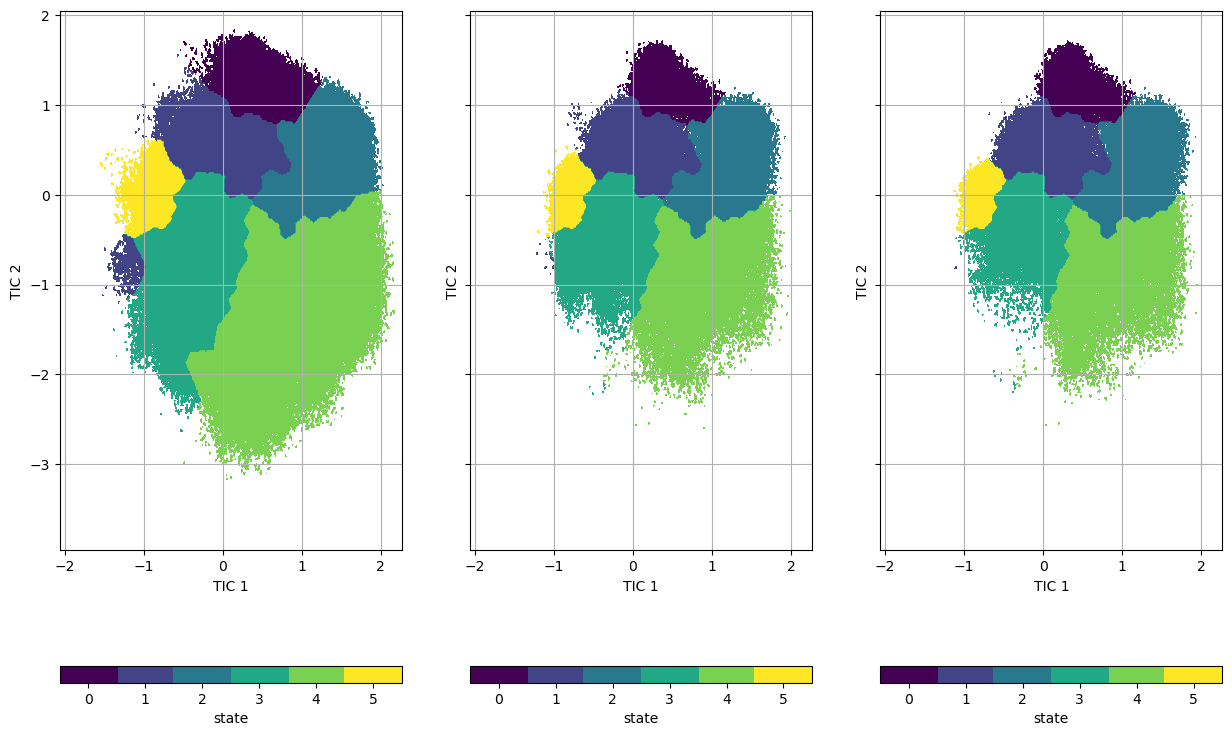

In [63]:
cols = ["orange", "yellow", "limegreen", "cyan", "royalblue", "magenta"]
# colsT = ["limegreen", "yellow", "orange", "magenta", "cyan", "royalblue"]
cmap = mpl.colors.ListedColormap(cols)
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 10), sharex=True, sharey=True)


pyemma.plots.plot_state_map(
    *tica_concatenated_full[:, :2].T,
    hmm_full.metastable_assignments[dtrajs_concatenated],
    ax=ax1,
    cmap='viridis',
    nbins=300,
    cbar=True,
    cbar_orientation="horizontal",
)
ax1.set_xlabel("TIC 1")
ax1.set_ylabel("TIC 2")
pyemma.plots.plot_state_map(
    *tica_concatenated_trim_lev[:, :2].T,
    np.asarray(hmm_full.metastable_assignments[dtrajs_trimmed_lev]).reshape(-1),
    ax=ax2,
    cmap='viridis',
    nbins=300,
    cbar=True,
    cbar_orientation="horizontal",
)
ax2.set_xlabel("TIC 1")
ax2.set_ylabel("TIC 2")
pyemma.plots.plot_state_map(
    *tica_concatenated_trim_ess[:, :2].T,
    np.asarray(hmm_full.metastable_assignments[dtrajs_trimmed_ess]).reshape(-1),
    ax=ax3,
    cmap='viridis',
    nbins=300,
    cbar=True,
    cbar_orientation="horizontal",
)
ax3.set_xlabel("TIC 1")
ax3.set_ylabel("TIC 2")
ax1.grid()
ax2.grid()
ax3.grid()

## Calculating Free Energy - HMM - Stationary
We calculate the Free Energy of the HMM. This calculation uses same Boltzmann equation we previously used.

In [64]:
# full
stationary_distribution = hmm_full.stationary_distribution
total_distribution = float(stationary_distribution.sum())
pi = stationary_distribution / total_distribution
hmm_full_free_energies = -np.log(pi)
min_full = np.min(hmm_full_free_energies)
hmm_full_free_energies -= np.min(hmm_full_free_energies)

# trimmed - LEV
stationary_distributionT = hmm_lev.stationary_distribution
total_distributionT = float(stationary_distributionT.sum())
piT = stationary_distributionT / total_distributionT
hmm_lev_free_energiesT = -np.log(piT)
hmm_lev_free_energiesT -= min_full
hmm_lev_free_energiesT -= np.min(hmm_lev_free_energiesT)

# trimmed - ESS
stationary_distributionT_ess = hmm_ess.stationary_distribution
total_distributionT_ess = float(stationary_distributionT_ess.sum())
piT_ess = stationary_distributionT_ess / total_distributionT_ess
hmm_ess_free_energiesT_ess = -np.log(piT_ess)
hmm_ess_free_energiesT_ess -= min_full
hmm_ess_free_energiesT_ess -= np.min(hmm_ess_free_energiesT_ess)

In [65]:
data['hmm_full_FES'] = hmm_full_free_energies
data['hmm_lev_free_FES'] = hmm_lev_free_energiesT
data['hmm_ess_free_FES'] = hmm_ess_free_energiesT_ess
df = pd.DataFrame(data)
# df_sorted = df.sort_values(by='Minimum Energy (PyEmma)')
display(df)


,State,Minimum Energy (PyEmma),Minimum Energy (PyEmmaT),Minimum Energy (PyEmmaT_ess),hmm_full_FES,hmm_lev_free_FES,hmm_ess_free_FES
0,0,2.200579,1.262412,0.063312,1.384359,0.981272,0.975427
1,1,2.310509,1.840294,0.845255,1.156407,0.443579,1.389288
2,2,2.717905,1.222496,0.468777,0.814797,0.000000,1.084454
3,3,2.947409,1.785378,1.068399,0.828891,0.499782,0.391341
4,4,3.552482,2.383909,0.904095,0.828450,1.220345,0.000000
5,5,0.000000,0.000000,0.000000,0.000000,0.376588,0.676475
